In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding,LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.utils import pad_sequences
from tensorflow.python.keras.models import load_model
import re
import nltk
nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv("/content/drive/MyDrive/IMDB-Dataset.csv")

In [6]:
# we are browsing the data
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
# the columns
data.columns

Index(['review', 'sentiment'], dtype='object')

In [8]:
data.shape

(50000, 2)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [10]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [13]:
print(data.sentiment.value_counts())

positive    25000
negative    25000
Name: sentiment, dtype: int64


In [14]:
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]

In [15]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [16]:
WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('english')

In [17]:
data['review'] = data['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
data['review'] = data['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

data['review'] = data['review'].apply(lambda x: x.lower())

data['review'] = data['review'].apply(lambda x: x.strip())

def token(values):
  words = nltk.tokenize.word_tokenize(values)
  filtered_words = [word for word in words if word not in set(stopwords.words("english"))]
  not_stopword_doc = " ".join(filtered_words)
  return not_stopword_doc
data['review'] = data['review'].apply(lambda x: token(x))

In [18]:
sentiment = data['sentiment'].values
sentiment

array([1, 1, 1, ..., 0, 0, 0])

In [19]:
data = data['review']

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data,sentiment,test_size = 0.2, random_state = 42)

<h2> Creating a Dictionary </h2>

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" > We create a dictionary of 15000 most used words in English for later use. </p> </li>
</ul>

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 15000)
tokenizer.fit_on_texts(data)

<h2> Bring the comments to the same size </h2>

<ul>
    <li > comments of different lengths cannot train the RNN/lstm/gru model. That's why we need to make the sentences the same size. </p> </li>
</ul>

In [22]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [23]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [24]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

283

In [25]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.94522

In [26]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens)

In [27]:
x_train_pad.shape

(40000, 283)

In [28]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [29]:
#normal comment
print(return_to_sentence(x_train_pad[9]))

thesis behind rise evil seems br br hitler bad man bad man hated jews case miss going fact every scene film br br effort whatsoever try explain mood time hitler may adopted views strategy needless say unlike generally excellent nazis warning history film neglected point fact nearly leaders munich communist rising jewish may views subject linking jews absolutely crucial aspect understanding much nazi era br br much understanding done film makers going go got stuff knew anyway certainly get fascinating fact hitler briefly socialist communist immediately ww would course far complex film handle might even detract relentless bad away incessantly br br know bad man however also know figure public speaker private situations could polite even sympathetic course views like anti alcohol anti smoking many guardian readers could agree also famously fond animals hence wholly invented dog scene absurd br br also accounts seen brave soldier ww whilst saw iron cross never get see acts bravery script n

In [30]:
print(x_train_pad[9])

[13091   383  2007   337    85     1     1  2009    16    44    16    44
  1631  4271   296   557    70    90    73    47     3     1     1   634
  1483   236  1096  1085     7  2009    95  5100  2607 10507  2961    49
   881  1136   203  3358  1591   353     3  6802   113    90   654  5903
 12551  4050  4072  2230    95  2607   651 14337  4271   294  4051  1134
  1600    14  2335   845     1     1    14  1600   114     3  1067    70
    52    82   388   536   426   298    15  1273    90  2009  3027 10865
  4050  1055  4753     9   152   117  1143     3  2639   124     8  6296
  6408    16   132 14759     1     1    41    16    44    92    19    41
   692   891  9927  1788   983    24  9296     8  2025   152  2607     5
   929  4560   929  2978    32  7414  5974    24   870    19 13846  4058
  1419  2742  5174  4992   644    47  1706     1     1    19  5810    33
  2622  1368  4753  1651   104  3813  1451    34    15    12  1241  9684
   120  2961    49    19    15  2437  1483  3671   

In [31]:
model = Sequential()

embedding_size = 50

model.add(Embedding(input_dim=15000,output_dim=embedding_size,input_length=max_tokens,name='embedding_layer'))

model.add(LSTM(units=16, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=8, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=4))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 283, 50)          750000    
                                                                 
 lstm (LSTM)                 (None, 283, 16)           4288      
                                                                 
 dropout (Dropout)           (None, 283, 16)           0         
                                                                 
 lstm_1 (LSTM)               (None, 283, 8)            800       
                                                                 
 dropout_1 (Dropout)         (None, 283, 8)            0         
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0

<ul>
    <li  style = "color:green" > <p style = "color:black;font-weight:bold" > we train our model.
 </p> </li>
</ul>

In [33]:
history = model.fit(x_train_pad, y_train, validation_split=0.3, epochs=5, batch_size=1000, shuffle=True, verbose = 1)

Epoch 1/5
28/28 [==============================] - 60s 2s/step - loss: 0.6853 - accuracy: 0.5653 - val_loss: 0.6583 - val_accuracy: 0.6712
Epoch 2/5
28/28 [==============================] - 57s 2s/step - loss: 0.5735 - accuracy: 0.7950 - val_loss: 0.5104 - val_accuracy: 0.8306
Epoch 3/5
28/28 [==============================] - 57s 2s/step - loss: 0.4562 - accuracy: 0.8685 - val_loss: 0.4498 - val_accuracy: 0.8433
Epoch 4/5
28/28 [==============================] - 59s 2s/step - loss: 0.3736 - accuracy: 0.9075 - val_loss: 0.4066 - val_accuracy: 0.8601
Epoch 5/5
28/28 [==============================] - 56s 2s/step - loss: 0.3142 - accuracy: 0.9327 - val_loss: 0.3889 - val_accuracy: 0.8583


In [34]:
result = model.evaluate(x_test_pad, y_test)

313/313 [==============================] - 30s 93ms/step - loss: 0.3846 - accuracy: 0.8627


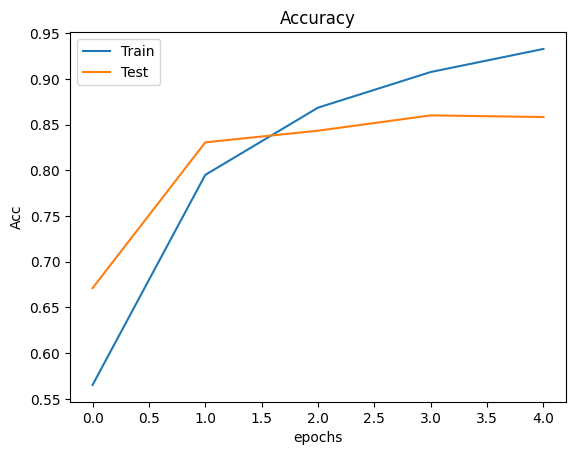

In [35]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

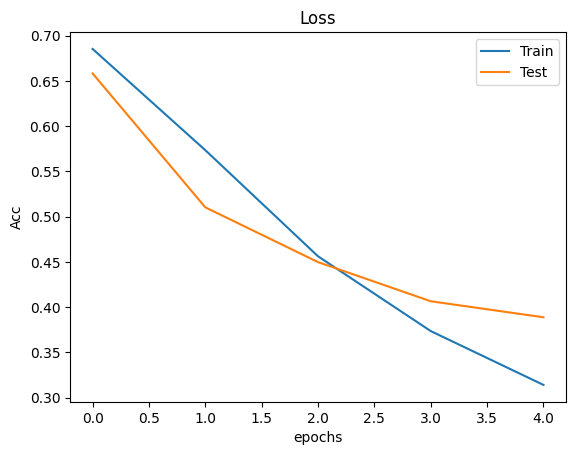

In [36]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()